# ShockWave

Analyze USGS earthqake data from 1970 to 2020. This equates to a total of X million earthquakes, Y million are magnitude 3 or greater. 

## ShockWave team members: 

  * John Burke
  * Ali Chunawala
  * Anderson Igben
  * Stanislav Kuzmin
  * Henry Wycislo

## Analize earthquake data

* Plot the earthquake locations
* Plot magnitudes of the earthquakes
* Show the magnitudes compared to the location
* Show collation of earthquakes around the ring of fire

## Questions to answer

* Has there been an increase of earthquakes greater than magnitude 3 since 1970?
* Is there an increase of the magnitude of earthquakes since 1970? 

# Note to project team members

* We have cleaned up the data and have shrunk the file by using a zip file and by removing columns that we don't need. 
* To work with this notebook - follow these steps:

1. copy the shockwave.ipynb file to your folder in git

2. cd to your folder in git from the command line and start your Jupiter notebook in your folder. 

   a. If your not a fan of the command line, however you start your notebook - just make sure your working with your copy in your folder. 

   b. After you get your part done, let HenryW know and I will merge your changes into the 'main' notebook for our project

   

   

   

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
import numpy as np
import requests
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm


# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy


# Load .env enviroment variables into the notebook
load_dotenv()
# Get the API key from the environment variable and store as Python variable
google_api_key = os.getenv("google_api_key")
#type(google_api_key)


In [2]:
# one month of test data 
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2021-01-01&endtime=2021-01-31'
tables = pd.read_csv(url)

quake_df = pd.DataFrame(tables)
quake_df.head()



,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-01-30T23:57:43.470Z,51.841833,-178.581000,22.48,1.44,ml,10.0,174.0,NaN,0.15,...,2021-02-01T00:31:05.880Z,"134 km W of Adak, Alaska",earthquake,1.42,0.92,0.347473,10.0,reviewed,av,av
1,2021-01-30T23:51:19.680Z,38.030167,-118.800167,9.59,1.87,md,25.0,103.0,0.292,0.05,...,2021-02-04T21:02:09.323Z,"27km SE of Bodie, CA",earthquake,0.22,2.53,0.253000,23.0,reviewed,nc,nc
2,2021-01-30T23:36:27.503Z,59.183200,-136.452400,7.60,1.70,ml,NaN,NaN,NaN,0.59,...,2021-02-12T20:50:18.719Z,"35 km SW of Covenant Life, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
3,2021-01-30T23:27:23.670Z,61.024800,-150.391900,16.60,1.40,ml,NaN,NaN,NaN,0.65,...,2021-02-12T20:50:18.483Z,"19 km NE of Point Possession, Alaska",earthquake,NaN,0.30,NaN,NaN,reviewed,ak,ak
4,2021-01-30T23:24:29.437Z,62.973900,-149.063900,77.00,1.20,ml,NaN,NaN,NaN,0.36,...,2021-02-12T20:50:18.265Z,Central Alaska,earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak


/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


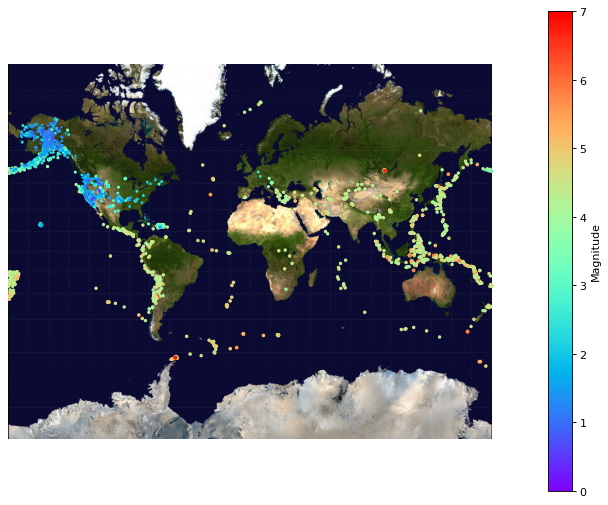

In [3]:
def latLonToOffsets(latitude, longitude, mapWidth, mapHeight):
    
    FE = 180
    radius = mapWidth / (2 * np.pi)
    latRad = np.array(latitude)/180*np.pi
    lonRad = (np.array(longitude) + FE)/180*np.pi
    x = lonRad * radius;
    yFromEquator = radius * np.log(np.tan(np.pi / 4 + latRad / 2))
    y = mapHeight / 2 - yFromEquator
    
    return [x, y]
    

from mpl_toolkits.axes_grid1 import make_axes_locatable

latitudeNY = 41.145556
longitudeNY = -73.995

latitudeML = -37.867579
longitudeML = 145.048621

img = mpimg.imread('Mercator_projection.jpg')

mapWidth=len(img[0])
mapHeight=len(img)

#ncoords=latLonToOffsets([latitudeNY,latitudeML], [longitudeNY,longitudeML], mapWidth, mapHeight)
xcoords=quake_df['latitude']
ycoords=quake_df['longitude']
mag=quake_df['mag']

ncoords=latLonToOffsets(xcoords, ycoords, mapWidth, mapHeight)
cmp = cm.rainbow

plt.figure(figsize=(mapWidth/200, mapHeight/200), dpi=80)
ax = plt.gca()
plt.imshow(img)
plt.axis('off')
plt.scatter(ncoords[0],ncoords[1],s=mag, c=mag,  marker='o',cmap=cmp, vmin=0,vmax=7)
plt.colorbar().set_label('Magnitude')
plt.show()


In [4]:
# There are a few months that had more than 20k earthquakes
# Made new list to do half months

# date_list = pd.date_range('1970-01-01','2021-08-01', 
#               freq='MS').strftime("%Y-%m-%d").tolist()

# use Semi Month frequency 15th and the last
#months = pd.date_range('1969-12-31','2021-08-01',freq='SM').strftime("%Y-%m-%d")
# moving to weekly - 2019-06-30 had over 20k earthquakes!! 
# pd.date_range('1969-12-01','2021-08-01', freq='SM').strftime("%Y-%m-%d").tolist()
date_list = pd.date_range('1969-12-01','2021-08-01', 
              freq='W').strftime("%Y-%m-%d").tolist()

len(date_list)

2696

In [5]:
# read date list, create copy of csv and load to tables series
# tables = []
# for x in range(len(date_list)-1):
#     start = date_list[x]
#     end = date_list[x+1]
#     url = f'https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime={start}&endtime={end}'
#     print(url)
#     df1 = pd.read_csv(url)
#     df1.to_csv(f"data/{start}_{end}.csv")
#     tables.append(df1)

In [6]:
# df = pd.concat(tables)
# # save all data to csv
# df.to_csv("data/all_earthquake_data.csv")
# df.head()

In [7]:
quake_df = pd.read_csv("../data/all_earthquake_data2.zip")
quake_df


,time,latitude,longitude,mag,place
0,1969-12-13T18:59:11.430Z,19.313000,-155.104000,2.78,"17 km S of Fern Forest, Hawaii"
1,1969-12-13T17:55:57.400Z,46.709000,-119.234333,1.60,"13 km SSW of Othello, Washington"
2,1969-12-13T13:03:04.570Z,19.466667,-155.487667,1.94,"26 km W of Volcano, Hawaii"
3,1969-12-13T12:53:50.580Z,19.443167,-155.248833,NaN,"1 km W of Volcano, Hawaii"
4,1969-12-13T10:43:38.000Z,19.304167,-155.210500,2.51,"15 km S of Volcano, Hawaii"
...,...,...,...,...,...
4053076,2021-07-25T00:14:10.316Z,62.637400,-150.151200,1.30,"21 km N of Chase, Alaska"
4053077,2021-07-25T00:05:08.190Z,19.228500,-155.453659,1.84,"3 km NE of P?hala, Hawaii"
4053078,2021-07-25T00:03:53.992Z,11.217900,-86.871700,4.50,"74 km SSW of Masachapa, Nicaragua"
4053079,2021-07-25T00:02:53.559Z,60.157700,-141.588500,1.10,"124 km WNW of Yakutat, Alaska"


In [8]:

# read all_earthquake data 
all_earthquake_data = pd.read_csv("../data/all_earthquake_data.csv")
all_earthquake_data


,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,0,1970-01-14T22:15:54.270Z,19.343833,-155.193167,4.658,1.86,ml,8.0,204.0,NaN,...,2020-03-31T16:15:44.310Z,"11 km SSE of Volcano, Hawaii",earthquake,1.72,1.28,NaN,1.0,reviewed,hv,hv
1,1,1970-01-14T22:14:58.690Z,19.340500,-155.193667,6.782,NaN,NaN,10.0,211.0,NaN,...,2020-03-31T16:15:44.110Z,"12 km SSE of Volcano, Hawaii",earthquake,1.75,2.27,NaN,NaN,reviewed,hv,hv
2,2,1970-01-14T21:17:40.630Z,19.282500,-155.247000,6.162,NaN,NaN,7.0,269.0,NaN,...,2020-03-31T16:15:43.910Z,"17 km S of Volcano, Hawaii",earthquake,1.15,2.54,NaN,NaN,reviewed,hv,hv
3,3,1970-01-14T18:44:20.840Z,37.545167,-118.407833,6.000,3.00,mh,6.0,234.0,NaN,...,2016-01-29T01:13:57.440Z,"18km N of Dixon Lane-Meadow Creek, CA",earthquake,3.43,31.61,0.387,12.0,reviewed,ci,ci
4,4,1970-01-14T17:29:39.910Z,19.406833,-155.450833,13.214,1.85,ml,10.0,256.0,NaN,...,2020-03-31T16:15:43.720Z,"22 km N of P?hala, Hawaii",earthquake,3.60,5.58,NaN,1.0,reviewed,hv,hv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,178,1970-04-30T07:50:38.780Z,34.147333,-117.261167,6.000,2.42,mh,7.0,110.0,0.6652,...,2016-01-29T01:29:11.080Z,"4km NE of San Bernardino, CA",earthquake,1.14,31.61,0.240,17.0,reviewed,ci,ci
1942,179,1970-04-30T07:45:45.880Z,19.314667,-155.227167,6.621,NaN,NaN,16.0,198.0,NaN,...,2020-03-31T16:33:25.540Z,"14 km S of Volcano, Hawaii",earthquake,0.98,1.32,NaN,NaN,reviewed,hv,hv
1943,180,1970-04-30T07:21:16.020Z,19.442667,-154.732000,3.445,NaN,NaN,4.0,337.0,NaN,...,2020-03-31T16:33:25.400Z,"19 km E of Leilani Estates, Hawaii",earthquake,13.77,5.75,NaN,NaN,reviewed,hv,hv
1944,181,1970-04-30T06:58:57.300Z,19.374667,-155.288000,27.836,2.73,ml,19.0,67.0,NaN,...,2020-03-31T16:33:25.260Z,"9 km SW of Volcano, Hawaii",earthquake,1.02,1.07,NaN,1.0,reviewed,hv,hv


In [9]:
quake_df.head()

,time,latitude,longitude,mag,place
0,1969-12-13T18:59:11.430Z,19.313000,-155.104000,2.78,"17 km S of Fern Forest, Hawaii"
1,1969-12-13T17:55:57.400Z,46.709000,-119.234333,1.60,"13 km SSW of Othello, Washington"
2,1969-12-13T13:03:04.570Z,19.466667,-155.487667,1.94,"26 km W of Volcano, Hawaii"
3,1969-12-13T12:53:50.580Z,19.443167,-155.248833,NaN,"1 km W of Volcano, Hawaii"
4,1969-12-13T10:43:38.000Z,19.304167,-155.210500,2.51,"15 km S of Volcano, Hawaii"


In [10]:
# Store latitude and longitude in locations
quake_df['year'] = pd.DatetimeIndex(quake_df['time']).year
locations = quake_df[["latitude", "longitude"]]
magnitude  = quake_df[['mag']].astype(float)
quake_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4053081 entries, 0 to 4053080
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   time       object 
 1   latitude   float64
 2   longitude  float64
 3   mag        float64
 4   place      object 
 5   year       int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 185.5+ MB


In [11]:
# Plot Heatmap
fig = gmaps.figure(zoom_level=2, center=[31.9686, -99.9018])



# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights = quake_df['mag'] > 3,
                                 dissipating=False, max_intensity=10,
                                 point_radius=1)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

NameError: name 'gmaps' is not defined

In [12]:
num_of_quakes_by_yr = quake_df['year'].value_counts()
num_of_quakes_by_yr.sort_index()

1969       400
1970      5657
1971      8672
1972      4957
1973      9994
1974     15139
1975     20377
1976     17975
1977     19608
1978     21420
1979     28231
1980     29391
1981     38819
1982     42401
1983     55344
1984     62469
1985     59094
1986     64769
1987     46523
1988     46911
1989     62091
1990     60454
1991     55425
1992     98341
1993     75120
1994     73237
1995     72225
1996     66105
1997     75361
1998     72315
1999     73050
2000     76297
2001     77089
2002     99451
2003    104090
2004    123003
2005    113412
2006    105501
2007     98301
2008    129320
2009     92061
2010    126845
2011    110971
2012    109522
2013    118764
2014    139921
2015    127072
2016    126595
2017    134606
2018    188723
2019    183415
2020    192297
2021     93950
Name: year, dtype: int64

In [13]:
quake_df['decade'] = quake_df['year'].apply(lambda x: str(x) [:3] + '0s')
quake_df

,time,latitude,longitude,mag,place,year,decade
0,1969-12-13T18:59:11.430Z,19.313000,-155.104000,2.78,"17 km S of Fern Forest, Hawaii",1969,1960s
1,1969-12-13T17:55:57.400Z,46.709000,-119.234333,1.60,"13 km SSW of Othello, Washington",1969,1960s
2,1969-12-13T13:03:04.570Z,19.466667,-155.487667,1.94,"26 km W of Volcano, Hawaii",1969,1960s
3,1969-12-13T12:53:50.580Z,19.443167,-155.248833,NaN,"1 km W of Volcano, Hawaii",1969,1960s
4,1969-12-13T10:43:38.000Z,19.304167,-155.210500,2.51,"15 km S of Volcano, Hawaii",1969,1960s
...,...,...,...,...,...,...,...
4053076,2021-07-25T00:14:10.316Z,62.637400,-150.151200,1.30,"21 km N of Chase, Alaska",2021,2020s
4053077,2021-07-25T00:05:08.190Z,19.228500,-155.453659,1.84,"3 km NE of P?hala, Hawaii",2021,2020s
4053078,2021-07-25T00:03:53.992Z,11.217900,-86.871700,4.50,"74 km SSW of Masachapa, Nicaragua",2021,2020s
4053079,2021-07-25T00:02:53.559Z,60.157700,-141.588500,1.10,"124 km WNW of Yakutat, Alaska",2021,2020s


In [14]:
seventies = quake_df.loc[(quake_df['decade'] == '1970s') & (quake_df['mag'] >= 3)]
num_of_quakes_70 = seventies['decade'].value_counts()
eighties = quake_df.loc[(quake_df['decade'] == '1980s') & (quake_df['mag'] >= 3)]
num_of_quakes_80 = eighties['decade'].value_counts()
nineties = quake_df.loc[(quake_df['decade'] == '1990s') & (quake_df['mag'] >= 3)]
num_of_quakes_90 = nineties['decade'].value_counts()
y2k = quake_df.loc[(quake_df['decade'] == '2000s') & (quake_df['mag'] >= 3)]
num_of_quakes_00 = y2k['decade'].value_counts()
y2k1 = quake_df.loc[(quake_df['decade'] == '2010s') & (quake_df['mag'] >= 3)]
num_of_quakes_10 = y2k1['decade'].value_counts()
y2k2 = quake_df.loc[(quake_df['year'] == 2020) & (quake_df['mag'] >= 3)]
print(f'Total Number to Earthquakes in {num_of_quakes_70}')
print(f'Total Number to Earthquakes in {num_of_quakes_80}')
print(f'Total Number to Earthquakes in {num_of_quakes_90}')
print(f'Total Number to Earthquakes in {num_of_quakes_00}')
print(f'Total Number to Earthquakes in {num_of_quakes_10}')

Total Number to Earthquakes in 1970s    40968
Name: decade, dtype: int64
Total Number to Earthquakes in 1980s    75568
Name: decade, dtype: int64
Total Number to Earthquakes in 1990s    125440
Name: decade, dtype: int64
Total Number to Earthquakes in 2000s    199869
Name: decade, dtype: int64
Total Number to Earthquakes in 2010s    187015
Name: decade, dtype: int64


In [15]:
num_of_quakes_by_dec = quake_df['decade'].value_counts()
num_of_quakes_by_dec.mean()

579011.5714285715

In [16]:
num_of_quakes_by_dec

2010s    1366434
2000s    1018525
1990s     721633
1980s     507812
2020s     286247
1970s     152030
1960s        400
Name: decade, dtype: int64

In [17]:
top10_quakes_all = quake_df.nlargest(10, 'mag')
top10_70s = seventies.nlargest(10, 'mag')
top10_80s = eighties.nlargest(10, 'mag')
top10_90s = nineties.nlargest(10, 'mag')
top10_00s = y2k.nlargest(10, 'mag')
top10_10s = y2k1.nlargest(10, 'mag')
#display(top10_quakes_all)
#display (top10_70s)


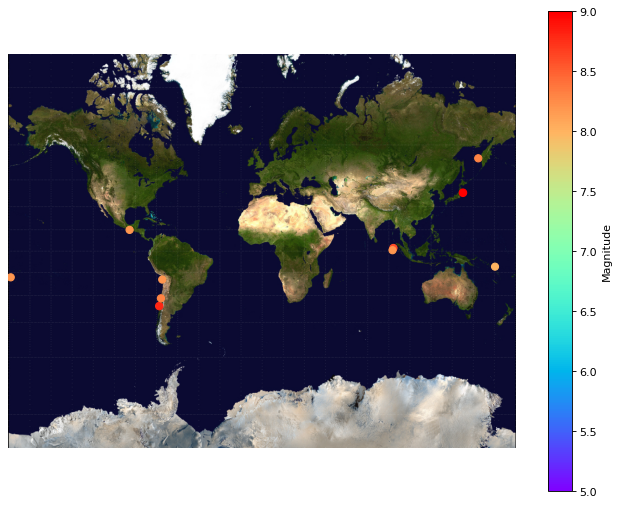

In [18]:
xcoords=top10_10s['latitude']
ycoords=top10_10s['longitude']
mag=top10_10s['mag']

ncoords=latLonToOffsets(xcoords, ycoords, mapWidth, mapHeight)
cmp = cm.rainbow

plt.figure(figsize=(mapWidth/200, mapHeight/200), dpi=80)
ax = plt.gca()
plt.imshow(img)
plt.axis('off')
plt.scatter(ncoords[0],ncoords[1],s=mag*5, c=mag,  marker='o',cmap=cmp, vmin=5,vmax=9)
plt.colorbar().set_label('Magnitude')
plt.show()

In [19]:
# import hvplot.pandas
seventies

,time,latitude,longitude,mag,place,year,decade
301,1970-01-03T19:48:40.840Z,33.960500,-116.830500,3.16,"6km NE of Banning, CA",1970,1970s
311,1970-01-03T02:51:58.400Z,37.298000,-122.088000,4.00,"5 km WSW of Cupertino, California",1970,1970s
312,1970-01-02T22:20:32.880Z,19.401000,-155.637833,3.23,"24 km ESE of Honaunau-Napoopoo, Hawaii",1970,1970s
316,1970-01-02T10:45:20.570Z,34.206000,-119.695667,3.14,"24km S of Santa Barbara, CA",1970,1970s
320,1970-01-01T19:49:24.730Z,37.433333,-118.743500,3.69,"27km WNW of West Bishop, CA",1970,1970s
...,...,...,...,...,...,...,...
152762,1979-12-30T06:25:48.700Z,-32.602000,-70.526000,5.20,"24 km NE of San Felipe, Chile",1979,1970s
152768,1979-12-30T04:18:33.800Z,52.525000,152.259000,5.40,northwest of the Kuril Islands,1979,1970s
152771,1979-12-30T02:15:32.400Z,-7.357000,129.212000,4.90,"275 km ENE of Lospalos, Timor Leste",1979,1970s
152772,1979-12-30T02:09:34.600Z,2.664000,-79.307000,4.30,"96 km W of Mosquera, Colombia",1979,1970s


(0.0, 20000.0)

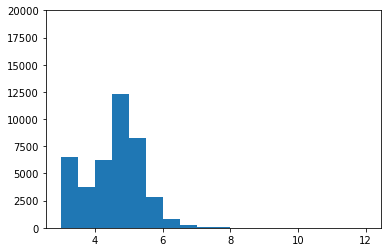

In [20]:
#seventies.plot.bar(x='mag', y='val')
bins_mag = [0, 1, 2, 3, 4,5,6,7,8,9,10,11,12]
bins_names=["1", "2", "3", "4","5","6","7","8","9","10","11","12"]
#seventies["Magnitudes"] = pd.cut(seventies["mag"], bins_mag, labels=bins_names)
#seventies_by_mag = seventies.groupby("Magnitudes")['mag'].count()
#seventies_by_mag.plot.bar()
fig, ax = plt.subplots()
ax.hist(x=seventies["mag"], bins=[3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12])
ax.set_ylim(0, 20000)

array([[<AxesSubplot:title={'center':'mag'}>]], dtype=object)

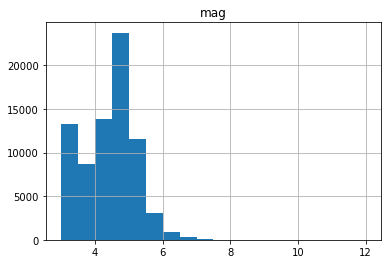

In [21]:
#eighties["Magnitudes"] = pd.cut(eighties["mag"], bins_mag, labels=bins_names)
#eighties_by_mag = eighties.groupby("Magnitudes")['mag'].count()
#eighties_by_mag.plot.bar()
eighties.hist(column='mag',bins=[3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12])

In [22]:
eighties.head(20)

,time,latitude,longitude,mag,place,year,decade
152324,1980-01-05T23:03:28.800Z,59.189,-150.6880,3.1,"54 km SE of Halibut Cove, Alaska",1980,1980s
152327,1980-01-05T22:28:31.400Z,21.996,121.6370,4.7,"92 km E of Hengchun, Taiwan",1980,1980s
152331,1980-01-05T20:35:47.300Z,6.201,126.5520,4.1,"45 km ESE of Pondaguitan, Philippines",1980,1980s
152335,1980-01-05T19:15:35.600Z,6.113,126.3790,4.6,"35 km SE of Pondaguitan, Philippines",1980,1980s
152338,1980-01-05T17:14:50.000Z,0.185,67.0050,4.9,Carlsberg Ridge,1980,1980s
152346,1980-01-05T15:50:43.700Z,6.095,126.4230,4.8,"40 km SE of Pondaguitan, Philippines",1980,1980s
152347,1980-01-05T14:32:26.200Z,45.034,7.4590,4.8,"1 km NE of Sangano, Italy",1980,1980s
152349,1980-01-05T14:12:10.200Z,-23.975,-66.4630,4.5,"30 km NNW of San Antonio de los Cobres, Argentina",1980,1980s
152355,1980-01-05T11:48:47.400Z,-6.659,130.6230,5.1,"261 km WSW of Tual, Indonesia",1980,1980s
152361,1980-01-05T08:44:44.900Z,6.134,126.5250,4.8,"45 km ESE of Pondaguitan, Philippines",1980,1980s


In [23]:
locations = top10_quakes_all[['latitude', 'longitude']]
weights = top10_quakes_all['mag']

fig = gmaps.figure(zoom_level=2, center=[31.9686, -99.9018])



# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights = weights,
                                 dissipating=False, max_intensity=10,
                                 point_radius=3)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

NameError: name 'gmaps' is not defined